In [1]:
%load_ext autoreload
%autoreload 2
# Set-up: Import numpy and assign GPU
from collections import defaultdict
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from tqdm.notebook import tqdm

from gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('1')

Using GPU:1


In [3]:
# Load Amazon WILDS pre-trained model
import statistics
import sys
import pickle
import numpy as np
import pandas as pd
import statistics


import torch
import torchvision.transforms as transforms

import argparse
import pdb

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from transforms_helenl import initialize_transform, getBertTokenizer
from wordcloud import WordCloud

sys.path.insert(0, './wilds/examples/')
os.environ["MODEL_DIR"] = '../models'
model_dir = '../models'

from algorithms.initializer import initialize_algorithm


In [4]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
#config_dict = pickle.load(open('amazon_config.txt', 'rb'))



full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')

In [7]:
 # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Create config with ERM algorithm
    config = Namespace(**new_dict)

    new_dict

{'dataset': 'civilcomments',
 'algorithm': 'ERM',
 'root_dir': 'data',
 'split_scheme': 'official',
 'dataset_kwargs': {},
 'download': False,
 'frac': 1.0,
 'version': None,
 'loader_kwargs': {'num_workers': 1, 'pin_memory': True},
 'train_loader': 'standard',
 'uniform_over_groups': False,
 'distinct_groups': None,
 'n_groups_per_batch': 4,
 'batch_size': 16,
 'eval_loader': 'standard',
 'model': 'distilbert-base-uncased',
 'model_kwargs': {},
 'transform': 'bert',
 'target_resolution': None,
 'resize_scale': None,
 'max_token_length': 300,
 'loss_function': 'cross_entropy',
 'loss_kwargs': {},
 'groupby_fields': ['black', 'y'],
 'group_dro_step_size': None,
 'coral_penalty_weight': 10.0,
 'irm_lambda': 1.0,
 'irm_penalty_anneal_iters': None,
 'algo_log_metric': 'accuracy',
 'val_metric': 'acc_wg',
 'val_metric_decreasing': False,
 'n_epochs': 5,
 'optimizer': 'AdamW',
 'lr': 1e-05,
 'weight_decay': 0.01,
 'max_grad_norm': 1.0,
 'optimizer_kwargs': {},
 'scheduler': 'linear_schedule_

In [18]:
def predict_augmented_labels(transform_name, aug_size):
    
    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 

    # Modify config with intended transformation
    new_dict['transform'] = transform_name

    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'

    
    # Generate training and evaluation transforms
    print(aug_size)
    train_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training = True, 
                                      aug_size = aug_size)
    
    # Prepare training data, loader, and grouper
    train_data = full_dataset.get_subset('train', transform=train_transform)
    train_loader = get_train_loader('standard', train_data, batch_size=64)
    train_grouper = CombinatorialGrouper(dataset=full_dataset, groupby_fields=config.groupby_fields)
    
    # Prepare training data, loader, and grouper
    eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False,
                                      aug_size = aug_size)
    
    
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    #return (eval_data.indices, eval_data.dataset)    


    eval_loader = get_eval_loader('standard', eval_data, batch_size = 64)
    
    # CODE TAKEN FROM WILDS TRAINING SCRIPTS:
    datasets = defaultdict(dict)
    for split in full_dataset.split_dict.keys():
        if split=='train':
            transform = train_transform
            verbose = True
        elif split == 'val':
            transform = eval_transform
            verbose = True
        else:
            transform = eval_transform
            verbose = False
        # Get subset
        datasets[split]['dataset'] = full_dataset.get_subset(
            split,
            frac=config.frac,
            transform=transform)

        if split == 'train':
            datasets[split]['loader'] = get_train_loader(
                loader=config.train_loader,
                dataset=datasets[split]['dataset'],
                batch_size=config.batch_size,
                uniform_over_groups=config.uniform_over_groups,
                grouper=train_grouper,
                distinct_groups=config.distinct_groups,
                n_groups_per_batch=config.n_groups_per_batch,
            **config.loader_kwargs)
        else:
            datasets[split]['loader'] = get_eval_loader(
                loader=config.eval_loader,
                dataset=datasets[split]['dataset'],
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)

    # Set fields
    datasets[split]['split'] = split
    datasets[split]['name'] = full_dataset.split_names[split]
    datasets[split]['verbose'] = verbose

    # Loggers
    # datasets[split]['eval_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_eval.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))
    # datasets[split]['algo_logger'] = BatchLogger(
    #     os.path.join(config.log_dir, f'{split}_algo.csv'), mode=mode, use_wandb=(config.use_wandb and verbose))

    print(transform_name)
    print("initialize model")
    # Initiate model and run on training set
    alg = initialize_algorithm(config, datasets, train_grouper)
    
    # TODO: pytorch load pretrained weights
    #alg.model.load_state_dict(torch.load('./best_model.pth'))
    alg.load_state_dict(torch.load('./best_model.pth')['algorithm'])
    alg.model.cuda()
    
    print("initialization complete")
    
    
    print("generating predictions")
    it = iter(eval_loader)
    predictions = []
    labels = []
    metadata = []
    
    for batch in tqdm(it):
        #pdb.set_trace()
        raw_pred = alg.model(batch[0].cuda()).cpu().detach().numpy()
        
        #softmax_prediction = sp.special.softmax(raw_pred.cpu().detach().numpy()).tolist()
        
        predictions.extend(raw_pred.tolist())
        labels.extend(batch[1].tolist())
        metadata.extend(batch[2].tolist()) # tensor of (64,16) for each batch

    

    print("writing predictions")
    file_name = './ERM_predictions/' + transform_name + ".npy"
    #file_name = './ERM_word_frequency_experiment/' + transform_name + "_aug_size_" + str(aug_size) + ".npy"
    
    with open(file_name, 'wb+') as file:
        np.save(file, predictions)
        np.save(file, labels)
        np.save(file, metadata)


    return (eval_data.indices, eval_data.dataset)    


In [12]:
def get_eval_dataset():
    """
    Returns a list of length 1 containing the indices of the WILDS dataset used to form the raw eval inputs. 
    
    """
    full_dataset = get_dataset(dataset='civilcomments', download=False, root_dir = './wilds/data')
    
    # Grab config generated by WILDS library from txt file
    infile = open('civilcomments_config.txt','rb')
    new_dict = vars(pickle.load(infile))
    infile.close() 


    # Create config with ERM algorithm
    config = Namespace(**new_dict)
    config.algorithm = 'ERM'
    
        # Prepare training data, loader, and grouper
    eval_transform = initialize_transform(transform_name=config.transform,
                                      config=config,
                                      dataset=full_dataset,
                                      is_training=False,
                                      aug_size = 1)
    
    eval_data = full_dataset.get_subset('test', transform=eval_transform)
    eval_indices = eval_data.indices.tolist()
    
    eval_inputs = [full_dataset[i] for i in eval_indices]
    return eval_inputs
        
        

In [49]:
eval_inputs = get_eval_dataset()


#eval_inputs = [full_dataset[i] for i in eval_indices]

eval_inputs

bert: 1


[('OH yes - Were those evil Christian Missionaries (many of whom were slaughtered by the Indians, or lost their lives due to disease, starvation etc.) lumped in with those "genocidists" you mention ? (yes I did make up a word, just as you make up stories).',
  tensor(1),
  tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1])),
 ("He's considered a good candidate for a cyber-security post? He couldn't even keep emails from his paramour secure.",
  tensor(0),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 ("Lela, you admit no records exist to support your claims of a restrained religious hoard, but then state the atheists are worse? It's all bad, but it's all within human nature. If we can do away with any of the cults involved we might lessen future occurrences.",
  tensor(0),
  tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])),
 ("I'll take the iffy libertarian over the guy who endorsed Hillary in the last race which was Trump by the way .. All the morons sho

In [17]:
predict_augmented_labels('bert')

bert
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

writing predictions


In [59]:
completed_augment_labels = ['bert'
                           'nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete']

in_progress = ['nlp_random_crop'
               , 'nlp_random_token_split'
               , 'nlp_back_translation_aug'
              ]


augmentations_requiring_model_download = ['nlp_random_similar_word_insertion_word2vec_embedding'
                           , 'nlp_random_similar_word_insertion_glove_embedding'
                           , 'nlp_random_similar_word_insertion_fasttext_embedding'
                           , 'nlp_random_similar_word_substitution_word2vec_embedding'
                           , 'nlp_random_similar_word_substitution_glove_embedding'
                           , 'nlp_random_similar_word_substitution_fasttext_embedding'
                           , 'nlp_random_similar_word_substitution_tfidf_embedding'   
]

'''
supported_augment_labels = [
                           'nlp_random_contextual_word_insertion_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_bert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_insertion_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_insertion_roberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_insertion_xlnet_embedding'
                           , 'nlp_random_contextual_word_insertion_bart_base_embedding'
                           , 'nlp_random_contextual_word_insertion_squeezebert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_bert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_uncased_embedding'
                           , 'nlp_random_contextual_word_substitution_distilbert_cased_embedding'
                           , 'nlp_random_contextual_word_substitution_roberta_embedding'
                           , 'nlp_random_contextual_word_substitution_distilroberta_base_embedding'
                           , 'nlp_random_contextual_word_substitution_xlnet_embedding'
                           , 'nlp_random_contextual_word_substitution_bart_base_embedding'
                           , 'nlp_random_contextual_word_substitution_squeezebert_uncased_embedding'
                           , 'nlp_contextual_sentence_insertion_gpt2_embedding'
                           , 'nlp_contextual_sentence_insertion_xlnet_cased_embedding'
                           , 'nlp_contextual_sentence_insertion_distilgpt2_embedding'
                           , 'nlp_abstractive_summarization_bart_large_cnn'
                           , 'nlp_abstractive_summarization_t5_small'
                           , 'nlp_abstractive_summarization_t5_base'
                           , 'nlp_abstractive_summarization_t5_large'
                           , 'nlp_wordnet_synonym'
                           , 'nlp_ppdb_synonym'
                           , 'nlp_antonym'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           , 'nlp_random_crop'
                           , 'nlp_random_token_split'
                           , 'nlp_back_translation_aug'
                           ]
'''

supported_augment_labels = [#'nlp_wordnet_synonym'
                           #, 'nlp_ppdb_synonym'
                           #'nlp_antonym'
                           'nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           , 'nlp_random_crop'
                           , 'nlp_random_token_split'
                           , 'nlp_back_translation_aug'
    
]

In [ ]:
predict_augmented_labels('nlp_contextual_sentence_insertion_gpt2_embedding', 1)

In [60]:
for augment in augmentations_requiring_model_download:
    predict_augmented_labels(augment)

nlp_random_similar_word_insertion_word2vec_embedding
initialize model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertClassifier: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN t

initialization complete
generating predictions


  0%|          | 0/2091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
def calculate_accuracy(prediction_file, sampling_percent = 0.8, num_runs = 10):
    logit_predictions = []
    labels = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file, allow_pickle = True)
        labels = np.load(file, allow_pickle = True)

    accuracy_scores = []
    
    total_dp = len(logit_predictions) #133782
    
    num_subsamples = int(total_dp * sampling_percent) #107025 for 133782 data points

    for i in tqdm(range(num_runs)):
        random_indices = np.random.choice(np.arange(total_dp), size = num_subsamples, replace = False)

        rand_logit_predictions = np.take(logit_predictions, random_indices, axis = 0)
        matching_labels = np.take(labels, random_indices)
        #print("labels_length", len(matching_labels))
        #print("samples_length", rand_logit_predictions[0])
        
        classified_predictions = []
        for prediction in rand_logit_predictions:
            index_prediction = np.argmax(prediction, axis = 0).tolist()
            classified_predictions.append(index_prediction)
    
        #print(len(classified_predictions))
        '''
        unique, counts = np.unique(np.array(classified_predictions), return_counts = True)
        print(unique, counts)
        print(len(labels))
        '''
    
        score = sklearn.metrics.accuracy_score(matching_labels, classified_predictions)
        #print(score)
        accuracy_scores.append(score)
    
    return accuracy_scores

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

calculate_accuracy('./ERM_predictions/bert.npy', num_runs = 2)

In [7]:
def calculate_recall(prediction_file):
    logit_predictions = []
    
    with open(prediction_file, 'rb') as file:
        logit_predictions = np.load(file)
        labels = np.load(file)
        
    #print(true_values)
    classified_predictions = []
    for prediction in logit_predictions:
        index_prediction = np.argmax(prediction, axis = 1).tolist()

        classified_predictions.extend(index_prediction)
            
    score = sklearn.metrics.recall_score(labels, classified_predictions)
    return score

In [26]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentations: list of strings, each corresponding to a supported augmentation
    
"""

def create_accuracy_graph(augmentations):
    
    aug_to_acc = []
    for augmentation in augmentations:
        file_name = './ERM_predictions/' + augmentation + ".npy"
        accuracies = calculate_accuracy(file_name)
        
        for i in range(len(accuracies)):
            accuracy = accuracies[i]
            aug_dict = {"augmentation":augmentation, "accuracy": accuracy, "batch_num": i}
            aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    fig, ax = plt.subplots()

    p = sns.boxplot(x = 'augmentation', y = 'accuracy', data = acc_df, ax = ax)#, order = acc_df['augmentation'])
    

    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    
    #print(p.containers[0])
    #p.bar_label(p.containers[0])
    #show_values(p)
    plt.rcParams['figure.figsize'] = (30,10)
    plt.show()


"""
Create graph comparing accuracy of all supported augmentations

Parameters:
    augmentations: list of strings, each corresponding to a supported augmentation
    
"""

def create_augmentation_impact_graph(augmentations):
    aug_to_mean_acc = []
    
    original_accuracy = statistics.mean(calculate_accuracy('./ERM_predictions/bert.npy'))

    print("original accuracy:", original_accuracy)
    
    for augmentation in augmentations:
        file_name = './ERM_predictions/' + augmentation + ".npy"
        accuracies = calculate_accuracy(file_name)
        augmentation_average_accuracy = statistics.mean(accuracies)
        
        print("AUG AVERAGE:", augmentation_average_accuracy)
        mean_accuracy = (augmentation_average_accuracy + original_accuracy) / 2
        
        print("MEAN WITH BERT:", mean_accuracy)

    

        augmentation_name = augmentation[4:] + "+bert" # remove 'nlp_' prefix in augmentation name
        
        aug_dict = {"augmentation":augmentation_name, "accuracy": mean_accuracy}
        aug_to_mean_acc.append(aug_dict)
    
    print(aug_to_mean_acc)
    acc_df = pd.DataFrame(aug_to_mean_acc).sort_values('accuracy', ascending = False)
    print(acc_df)
    
    sns.set(rc = {'figure.figsize':(30,10)})
    p = sns.barplot(x = 'augmentation', y = 'accuracy', data = acc_df, ci = None)
    p.set(ylim = (0.8, 1))
    

    #ax.figure.set_size_inches(200,10)
    
    
    

In [57]:
supported_augment_labels = ['bert'
                           , 'nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete'
                           #, 'nlp_random_crop'
                           #, 'nlp_random_token_split'
                           #, 'nlp_back_translation_aug'
                           ]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                    augmentation  accuracy  batch_num
7                           bert  0.926942          7
4                           bert  0.926896          4
5                           bert  0.926671          5
0                           bert  0.926634          0
8                           bert  0.926550          8
..                           ...       ...        ...
29                  nlp_keyboard  0.909591          9
26                  nlp_keyboard  0.909544          6
45  nlp_random_char_substitution  0.909451          5
28                  nlp_keyboard  0.909432          8
25                  nlp_keyboard  0.909180          5

[100 rows x 3 columns]


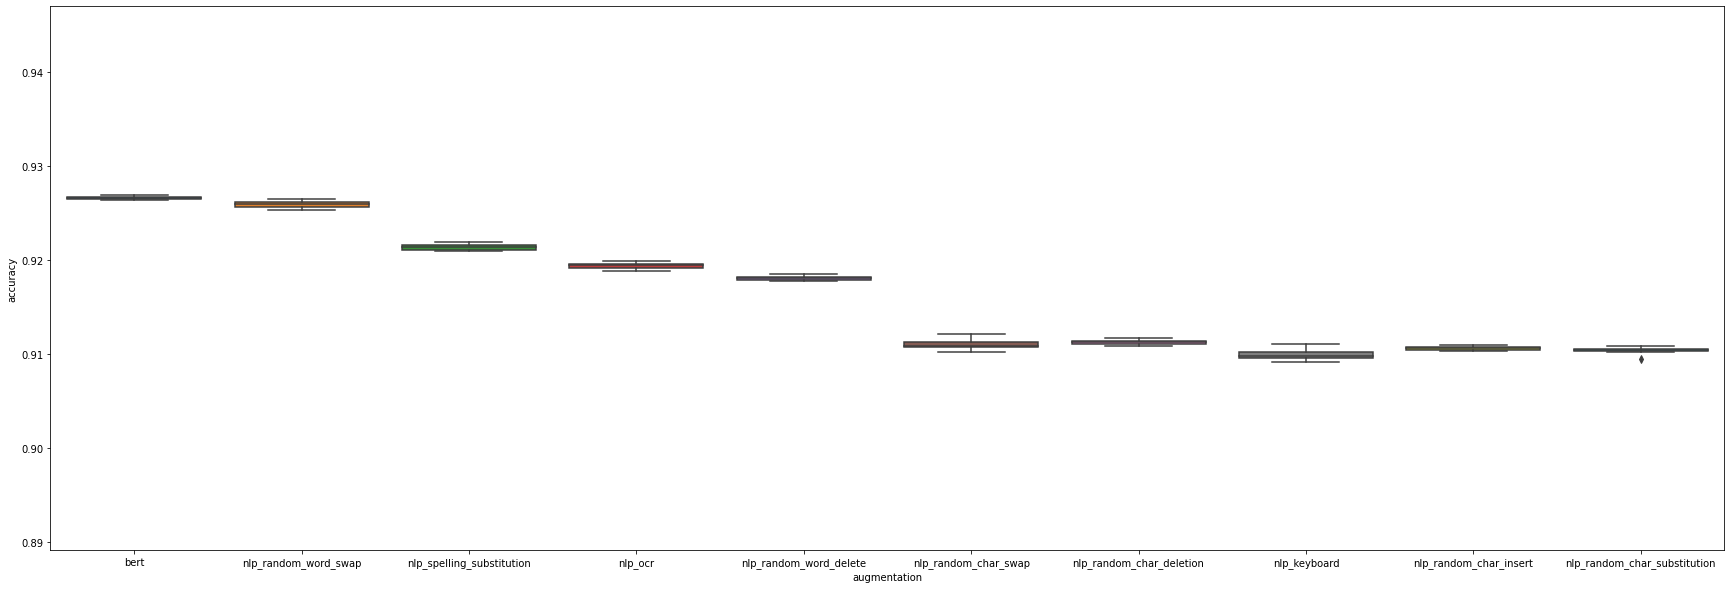

In [60]:
create_accuracy_graph(supported_augment_labels)
#create_accuracy_graph(['bert'])

  0%|          | 0/10 [00:00<?, ?it/s]

original accuracy: 0.9264573697734174


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.926615276804485
MEAN WITH BERT: 0.9265363232889512


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9194431207661762
MEAN WITH BERT: 0.9229502452697969


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9100238262088297
MEAN WITH BERT: 0.9182405979911236


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9105414622751693
MEAN WITH BERT: 0.9184994160242934


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9106106049988321
MEAN WITH BERT: 0.9185339873861247


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9106694697500584
MEAN WITH BERT: 0.9185634197617378


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.911381452931558
MEAN WITH BERT: 0.9189194113524877


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9216622284512964
MEAN WITH BERT: 0.9240597991123569


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9257164213968699
MEAN WITH BERT: 0.9260868955851437


  0%|          | 0/10 [00:00<?, ?it/s]

AUG AVERAGE: 0.9183097407147862
MEAN WITH BERT: 0.9223835552441018
[{'augmentation': '+bert', 'accuracy': 0.9265363232889512}, {'augmentation': 'ocr+bert', 'accuracy': 0.9229502452697969}, {'augmentation': 'keyboard+bert', 'accuracy': 0.9182405979911236}, {'augmentation': 'random_char_insert+bert', 'accuracy': 0.9184994160242934}, {'augmentation': 'random_char_substitution+bert', 'accuracy': 0.9185339873861247}, {'augmentation': 'random_char_swap+bert', 'accuracy': 0.9185634197617378}, {'augmentation': 'random_char_deletion+bert', 'accuracy': 0.9189194113524877}, {'augmentation': 'spelling_substitution+bert', 'accuracy': 0.9240597991123569}, {'augmentation': 'random_word_swap+bert', 'accuracy': 0.9260868955851437}, {'augmentation': 'random_word_delete+bert', 'accuracy': 0.9223835552441018}]
                    augmentation  accuracy
0                          +bert  0.926536
8          random_word_swap+bert  0.926087
7     spelling_substitution+bert  0.924060
1                       oc

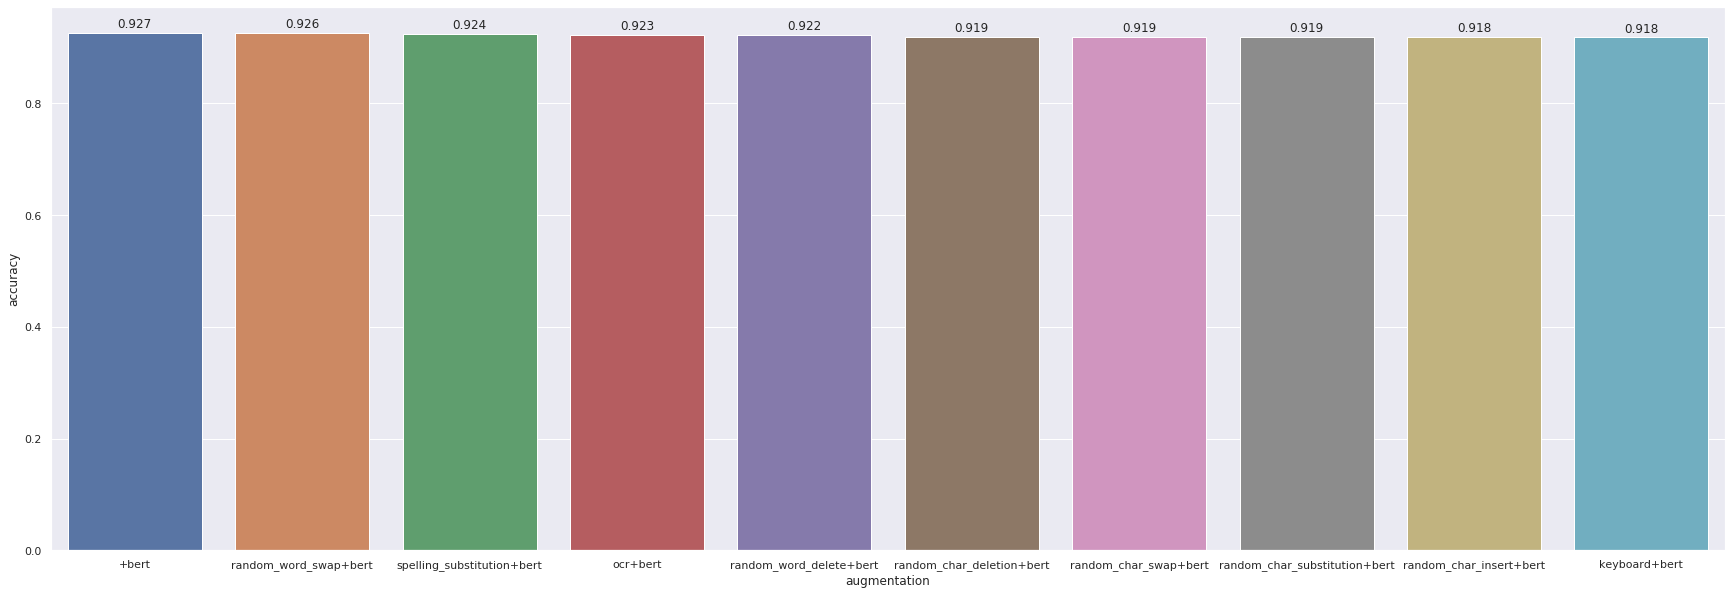

In [10]:
create_augmentation_impact_graph(supported_augment_labels)

In [ ]:
# PLOT: corruptions vs. corrections
# subsample 80% to create error bars -> add more rows for each run to generate error bars
        
# TFIDF 33 hours RT: check gpustat; is implementation necessary for our experiments?

# Report group-specific accuracy (identities; detecting hate-speech towards specific groups)
    # Similar corruptions vs. corrections
    # See WILDS documentation for metadata
    # Make one for each augmentation (x axis identity group, y axis performance)

    
# Modify parameter of how many modifications there are (1 word, 2 words)
    # x is intensity of augmentation, y is accuracy
    # For a specific augmentation, how does average response change (higher intensity + original)

# x-axis: number of draws, y-axis: average performance across draws
    # Up to 20 or 50 draws of words to delete/characters to augment
    # up to 50 for words, 100 for char 

In [6]:
# CORRUPTIONS VS. CORRECTIONS GRAPH

"""
Function that calculates raw number of corrections and corruptions generated by an augmentation.

Parameters:
    
    aug_pred_file: String containing path to .npy file with logit predictions and labels from augmentation model.
    original_pred_file: String containing path to .npy file with logit predictions and labels from original model.
    
Returns:

    corrections_corruptions_dict: Dictionary with two entries: "corruptions" key mapped to number (int) of raw corruptions created by augmentation,
                                    and "corrections" key mapped to number (int) of raw corrections created by augmentation.
    

"""
def calculate_corrections_corruptions(aug_pred_file, original_pred_file):
    aug_logit_predictions = []
    aug_classified_predictions = []
    
    original_logit_predictions = []
    original_classified_predictions = []
    
    aug_labels = []
    original_labels = []
    
    with open(aug_pred_file, 'rb') as aug_file:
        aug_logit_predictions = np.load(aug_file, allow_pickle = True)
        aug_labels = np.load(aug_file, allow_pickle = True)
    
    with open(original_pred_file, 'rb') as original_file:
        original_logit_predictions = np.load(original_file, allow_pickle = True)
        original_labels = np.load(original_file, allow_pickle = True)
        
    assert aug_labels.all() == original_labels.all(), "Test set labels do not match between aug. and original."
    assert aug_labels.size == 133782
    assert original_labels.size == 133782
    
    for prediction in aug_logit_predictions:
        index_prediction = np.argmax(prediction).tolist()
        
        aug_classified_predictions.append(index_prediction)
    
    for prediction in original_logit_predictions:
        index_prediction = np.argmax(prediction).tolist()
        
        original_classified_predictions.append(index_prediction)
    
    
    corrections_count = 0
    corrections_indices = []
    
    corruptions_count = 0
    corruptions_indices = []
    
    for i in range(len(aug_labels)):
        label = original_labels[i]
        original_pred = original_classified_predictions[i]
        aug_pred = aug_classified_predictions[i]
        
        
        # if corruption
        if (original_pred == label and aug_pred != label):
            corruptions_count += 1
            corruptions_indices.append(i)
        
        # if correction
        elif (original_pred != label and aug_pred == label):
            corrections_count += 1
            corrections_indices.append(i)
    
    corrections_corruptions_dict = {"num_corrections": corrections_count
                                    , "num_corruptions": corruptions_count
                                   , "corrections_indices": corrections_indices
                                   , "corruptions_indices": corruptions_indices}
    
    return corrections_corruptions_dict
    

In [7]:
def create_corrections_corruptions_plots(accuracy_file_paths):
    aug_to_corrections_corruptions = []
    
    for file_name in accuracy_file_paths:
        original_file_name = './ERM_predictions/bert.npy'
        
        corrections_corruptions_dict = calculate_corrections_corruptions(file_name, original_file_name)
        
        corrections = corrections_corruptions_dict["corrections"]
        corruptions = corrections_corruptions_dict["corruptions"]
        
        print(file_name)
        
        augmentation = int(file_name.split('/')[-1].split('.')[0].split('_')[-1])
        aug_dict = {"augmentation":augmentation, "corrections": corrections, "corruptions": corruptions}
        aug_to_corrections_corruptions.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_corrections_corruptions)
    #print(acc_df)
    
    acc_df_melted = acc_df.reset_index().melt(id_vars = 'augmentation')
    acc_df_melted = acc_df_melted[acc_df_melted.variable != 'index']
    
    print(acc_df_melted)
    

    sns.set(rc = {'figure.figsize':(30,10)})
    p = sns.barplot(x = 'augmentation', y = 'value', hue = 'variable', data = acc_df_melted, ci = False, palette = ["green", "red"])#, order = acc_df['augmentation'])

    #p = sns.boxplot(x = 'augmentation', y = 'value', hue = 'variable', data = acc_df_melted, palette = ["green", "red"])#, order = acc_df['augmentation'])
    show_values(p)


    

                    augmentation     variable  value
9                        nlp_ocr  corrections   1938
10                  nlp_keyboard  corrections   2440
11        nlp_random_char_insert  corrections   2576
12  nlp_random_char_substitution  corrections   2512
13          nlp_random_char_swap  corrections   2389
14      nlp_random_char_deletion  corrections   2228
15     nlp_spelling_substitution  corrections   1701
16          nlp_random_word_swap  corrections   1062
17        nlp_random_word_delete  corrections   1796
18                       nlp_ocr  corruptions   2901
19                  nlp_keyboard  corruptions   4673
20        nlp_random_char_insert  corruptions   4730
21  nlp_random_char_substitution  corruptions   4664
22          nlp_random_char_swap  corruptions   4508
23      nlp_random_char_deletion  corruptions   4280
24     nlp_spelling_substitution  corruptions   2557
25          nlp_random_word_swap  corruptions   1140
26        nlp_random_word_delete  corruptions 

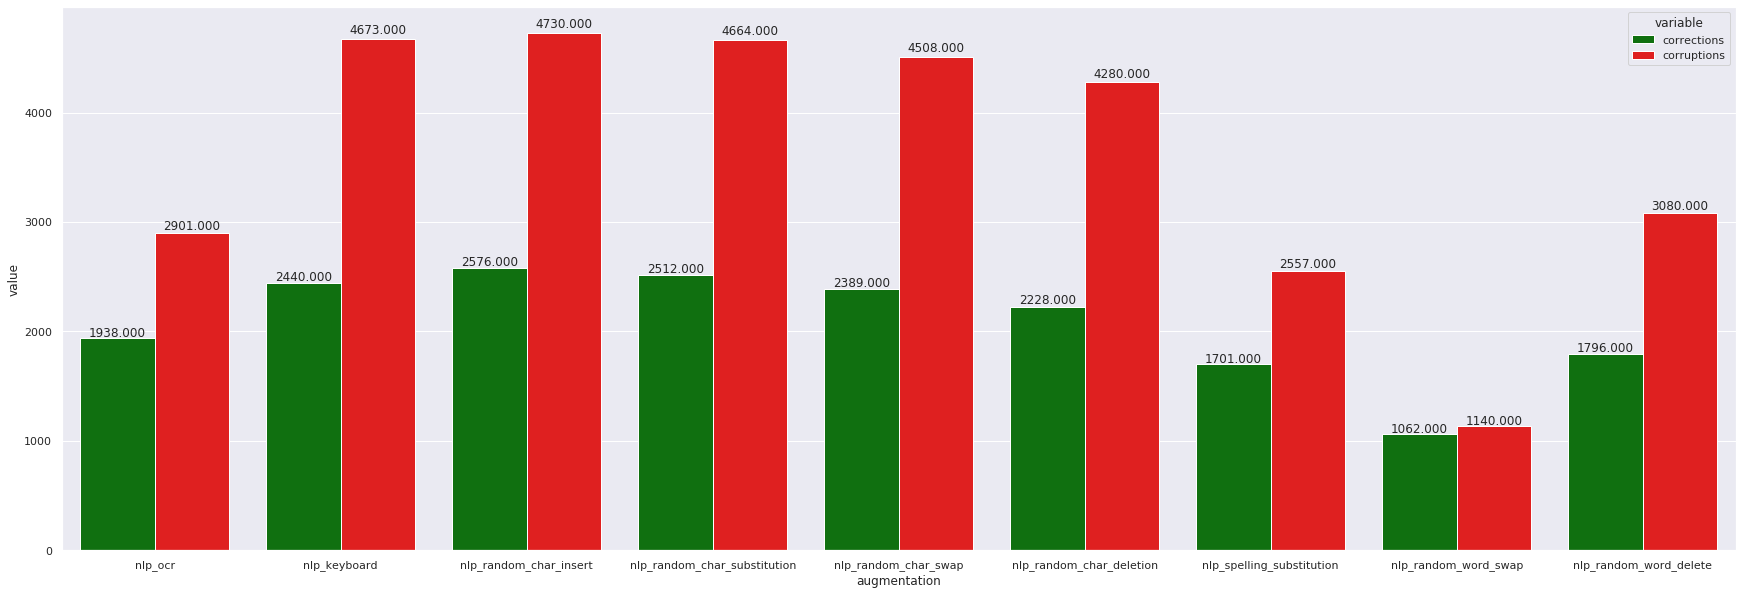

In [121]:
supported_augment_labels = ['nlp_ocr'
                           , 'nlp_keyboard'
                           , 'nlp_random_char_insert'
                           , 'nlp_random_char_substitution'
                           , 'nlp_random_char_swap'
                           , 'nlp_random_char_deletion'
                           , 'nlp_spelling_substitution'
                           , 'nlp_random_word_swap'
                           , 'nlp_random_word_delete']

file_paths = []

for augmentation in supported_augment_labels:
    file_name = './ERM_predictions/' + augmentation + ".npy"
    file_paths.append(file_Name)



create_corrections_corruptions_plots(file_paths)

In [ ]:
word_experiments_dir = 'ERM_word_frequency_experiment'

experiment_file_paths = []

for filename in os.listdir(word_experiments_dir):
    full_path = './' + word_experiments_dir + '/' + filename

    if os.path.isfile(full_path):
        experiment_file_paths.append(full_path)
        
create_corrections_corruptions_plots(experiment_file_paths)

In [14]:
def extract_corrections_corruptions_inputs(augmentation_file_path, standard_file_path, correction_corruption_type):
    """
    Retrieves comments, labels, and metadata for either corrections or corruptions made by a provided augmentation.

    Parameters:
        augmentation_file_path:      String denoting full path to augmentation prediction file.
        standard_file_path:          String denoting full path to non-augmented prediction file.
        correction_corruption_type:  Either "correction" or "corruption" to indicate if correction or corruption data is to be returned.

    Returns:
        A tuple of length 3, with :
            - the first index containing a list of the comments (type string) of interest.
            - the second index containing a list of labels (type int) for each of the comments in the first index.
                - the third index containing a list of tensors containing the metadata for each of the comments in the first index.
"""
    
    eval_inputs = get_eval_dataset()
    print(eval_inputs)
    corrections_corruptions_dict = calculate_corrections_corruptions(augmentation_file_path, standard_file_path)
    
    if correction_corruption_type == 'correction':
        indices = corrections_corruptions_dict['corrections_indices']
        
    elif correction_corruption_type == 'corruption':
        indices = corrections_corruptions_dict['corruptions_indices']
    
    inputs = []
    labels = []
    metadata = []
    
    for i in indices:
        inputs.append(eval_inputs[i][0])
        labels.append(eval_inputs[i][1].item())
        metadata.append(eval_inputs[i][2])
        
    return (inputs, labels, metadata)

In [10]:
def create_word_cloud(comments_list, stopwords = set()):
    """
    Creates a wordcloud.
    
    Parameters:
        comments_list: List of strings to be used as inputs into the wordcloud.
        stopwords:     Set of words to be excluded from wordcloud. 
                       Default value is an empty set (so that all input words will be included in forming wordcloud.)
                       If None is passed in, WordCloud library's STOPWORDS list will be used as words to be excluded.
    
    Returns:
        None.
    """
    words = ""
    
    for comment in comments_list:
 
        # split the value
        tokens = comment.split()
     
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
     
    words += " ".join(tokens)+" "
 
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [15]:
del_10_corrections_inputs = extract_corrections_corruptions_inputs('./ERM_word_frequency_experiment/nlp_random_word_delete_aug_size_10.npy'
                                                                   , './ERM_predictions/bert.npy'
                                                                   , 'correction')

del_10_corrections_labels = del_10_corrections_inputs[1]

tox_corrected = sum(del_10_corrections_labels)
nontox_corrected = len(del_10_corrections_labels) - tox_corrected

print("toxic corrected:", tox_corrected) # toxic comments mislabeled by BERT as nontoxic but corrected with augmentation
print("nontoxic corrected:", nontox_corrected) # nontoxic comments mislabeled by BERT as toxic but corrected with augmentation

bert: 1


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



toxic corrected: 465
nontoxic corrected: 1469


In [17]:
del_10_corruptions_inputs = extract_corrections_corruptions_inputs('./ERM_word_frequency_experiment/nlp_random_word_delete_aug_size_10.npy'
                                                                   , './ERM_predictions/bert.npy'
                                                                   , 'corruption')

del_10_corruptions_labels = del_10_corruptions_inputs[1]

tox_corrupted = sum(del_10_corruptions_labels)
nontox_corrupted = len(del_10_corruptions_labels) - tox_corrupted

print("toxic corrupted:", tox_corrupted) # toxic comments correctly labeled by BERT as toxic but corrupted with augmentation
print("nontoxic corrupted:", nontox_corrupted) # nontoxic comments correctly labeled by BERT as nontoxic but corrupted with augmentation

bert: 1


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



toxic corrupted: 3075
nontoxic corrupted: 856


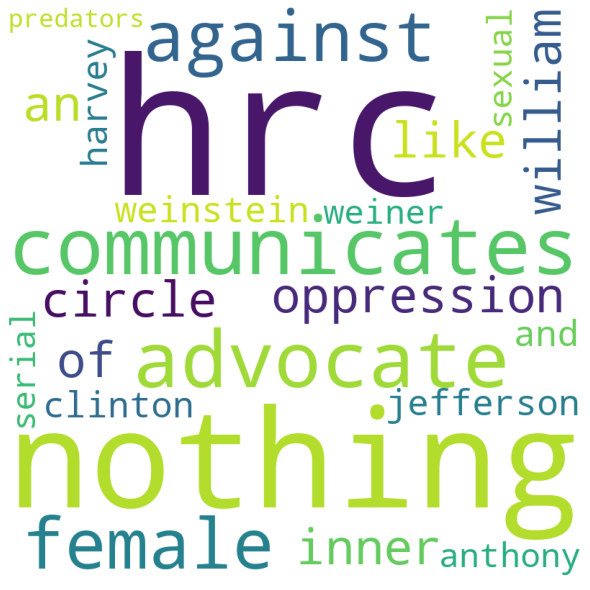

In [16]:
create_word_cloud(del_10_corrections_inputs[0])

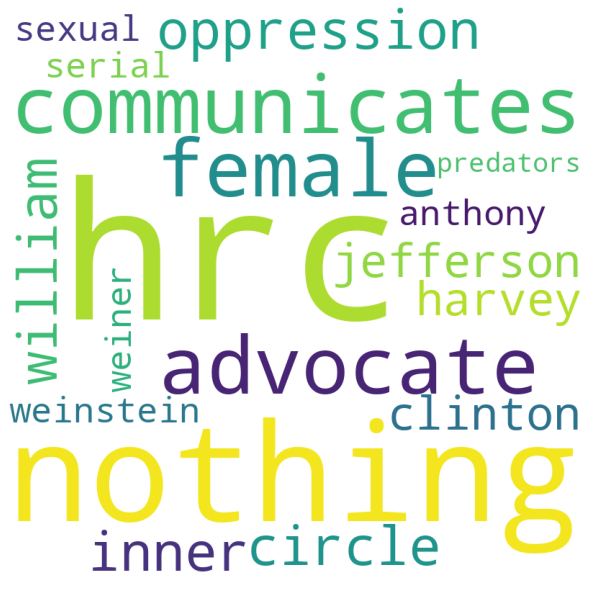

In [19]:
create_word_cloud(del_10_corrections_inputs[0], None)

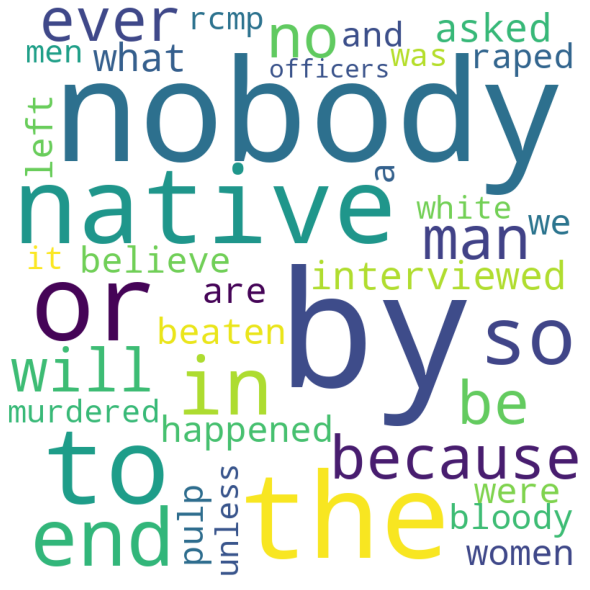

In [25]:
# word cloud of inputs that were mislabeled as nontoxic by BERT but corrected by augmentation
create_word_cloud([del_10_corrections_inputs[0][i] 
                   for i in range(len(del_10_corrections_inputs[1])) 
                   if del_10_corrections_inputs[1][i] == 1])

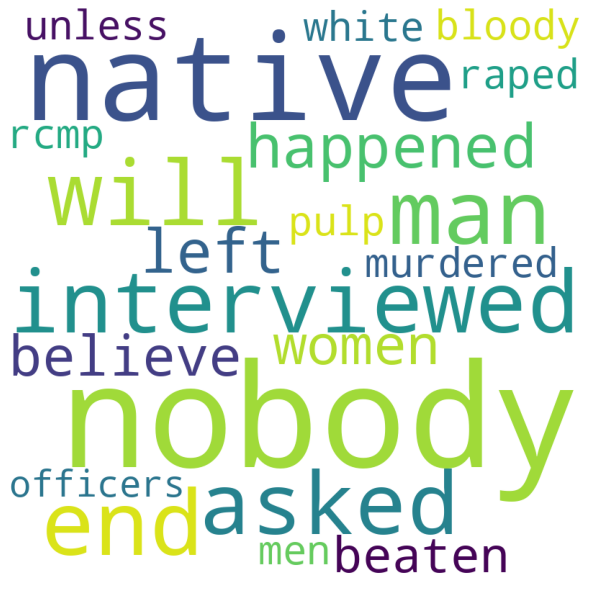

In [27]:
# word cloud of inputs that were mislabeled as nontoxic by BERT but corrected by augmentation
create_word_cloud([del_10_corrections_inputs[0][i] 
                   for i in range(len(del_10_corrections_inputs[1])) 
                   if del_10_corrections_inputs[1][i] == 1]
                 , None)

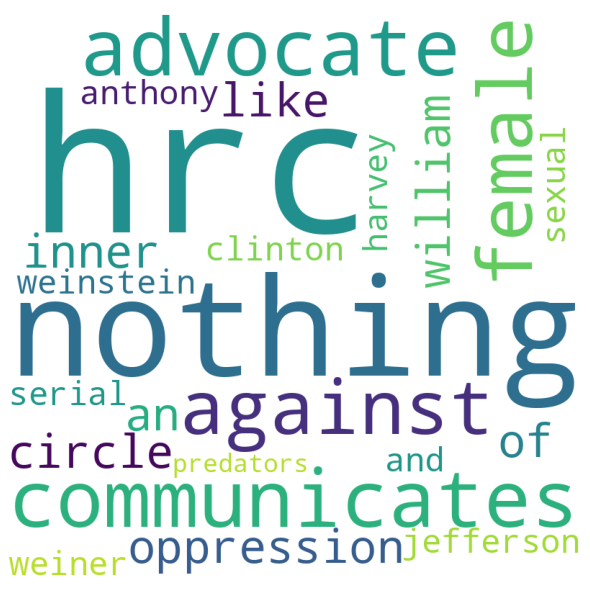

In [26]:
# word cloud of inputs that were mislabeled as nontoxic by BERT but corrected by augmentation
create_word_cloud([del_10_corrections_inputs[0][i] 
                   for i in range(len(del_10_corrections_inputs[1])) 
                   if del_10_corrections_inputs[1][i] == 0])

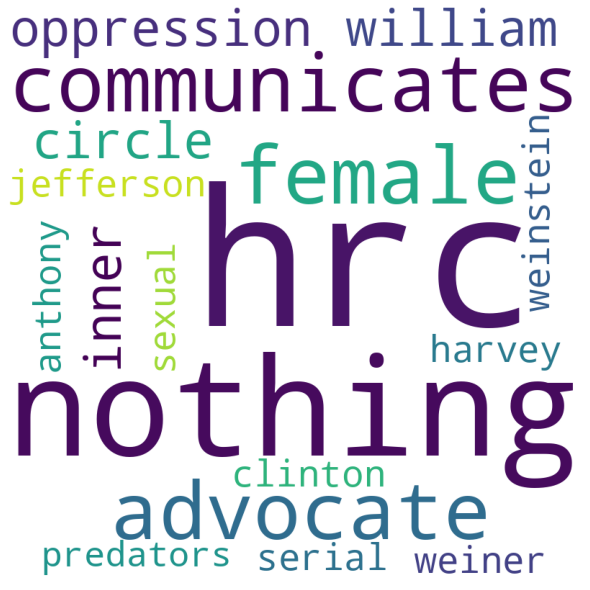

In [28]:
# word cloud of inputs that were mislabeled as nontoxic by BERT but corrected by augmentation
create_word_cloud([del_10_corrections_inputs[0][i] 
                   for i in range(len(del_10_corrections_inputs[1])) 
                   if del_10_corrections_inputs[1][i] == 0]
                 , None)

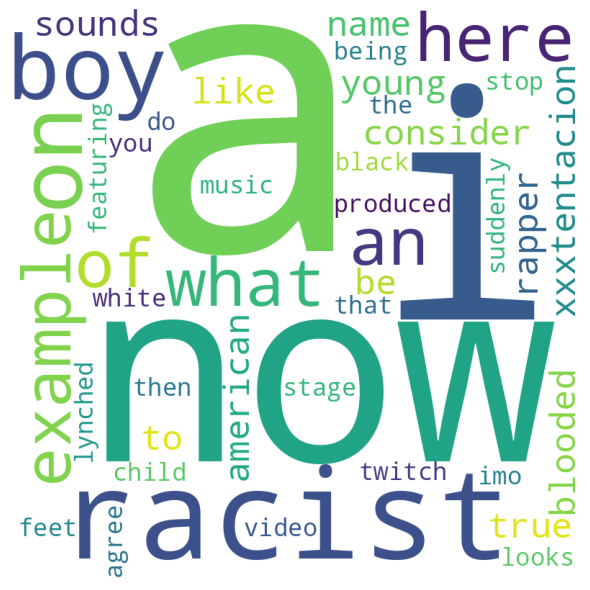

In [18]:
create_word_cloud(del_10_corruptions_inputs[0])

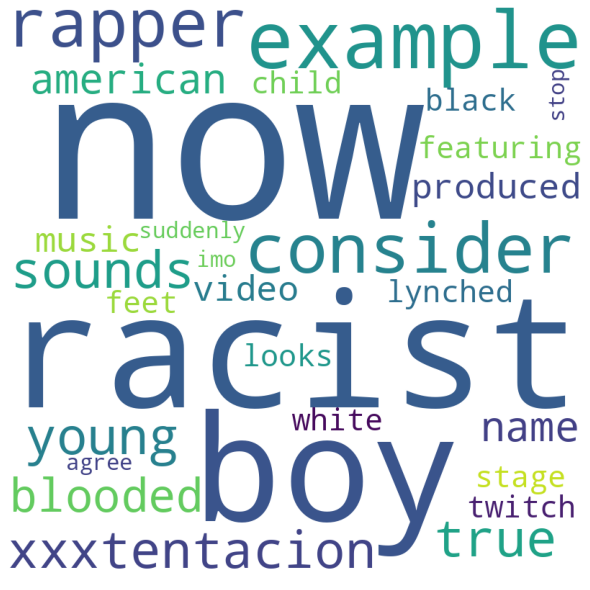

In [20]:
create_word_cloud(del_10_corruptions_inputs[0], None)

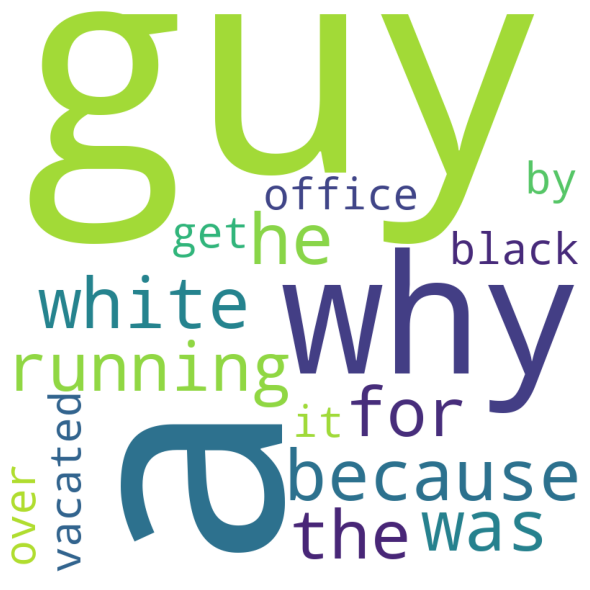

In [29]:
# word cloud of inputs that were correctly labeled as toxic by BERT but corrupted by augmentation
create_word_cloud([del_10_corruptions_inputs[0][i] 
                   for i in range(len(del_10_corruptions_inputs[1])) 
                   if del_10_corruptions_inputs[1][i] == 1])

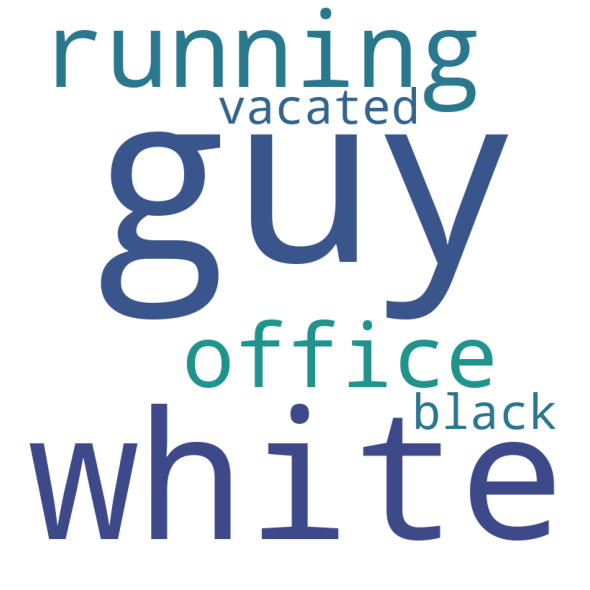

In [30]:
# word cloud of inputs that were correctly labeled as toxic by BERT but corrupted by augmentation
create_word_cloud([del_10_corruptions_inputs[0][i] 
                   for i in range(len(del_10_corruptions_inputs[1])) 
                   if del_10_corruptions_inputs[1][i] == 1]
                 , None)

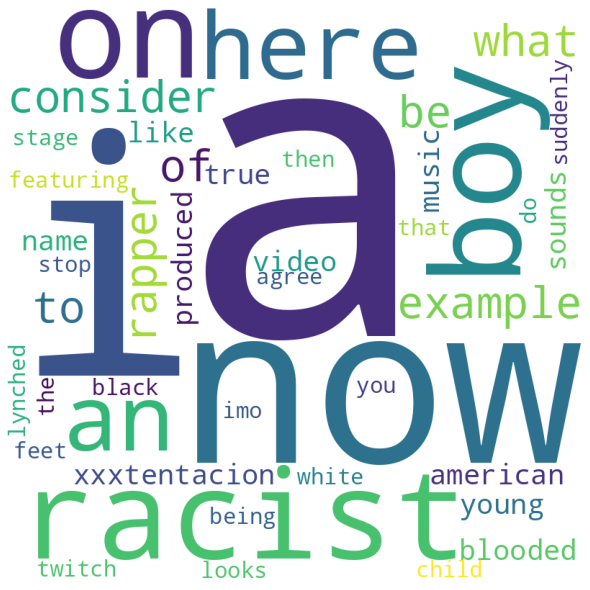

In [31]:
# word cloud of inputs that were correctly labeled as nontoxic by BERT but corrupted by augmentation
create_word_cloud([del_10_corruptions_inputs[0][i] 
                   for i in range(len(del_10_corruptions_inputs[1])) 
                   if del_10_corruptions_inputs[1][i] == 0]
                 )

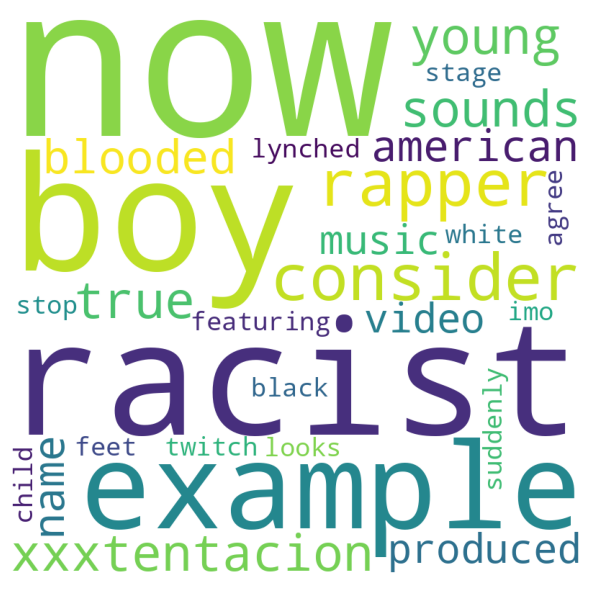

In [32]:
# word cloud of inputs that were correctly labeled as nontoxic by BERT but corrupted by augmentation
create_word_cloud([del_10_corruptions_inputs[0][i] 
                   for i in range(len(del_10_corruptions_inputs[1])) 
                   if del_10_corruptions_inputs[1][i] == 0]
                  , None)

9.0
90.0
Freedman–Diaconis number of bins: 14


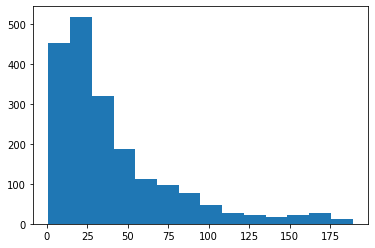

In [34]:
del_10_corrections_comment_length = []

for comment in del_10_corrections_inputs[0]:
    comment_length = len(comment.split())
    del_10_corrections_comment_length.append(comment_length)
    

q10, q90 = np.percentile(del_10_corrections_comment_length, [10, 90])
print(q10)
print(q90)
bin_width = 2 * (q90 - q10) * len(del_10_corrections_comment_length) ** (-1/3)
bins = round((max(del_10_corrections_comment_length) - min(del_10_corrections_comment_length)) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(del_10_corrections_comment_length, bins=bins);

7.0
72.0
Freedman–Diaconis number of bins: 23


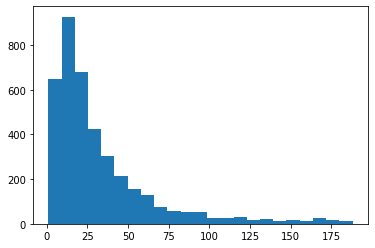

In [33]:
del_10_corruptions_comment_length = []

for comment in del_10_corruptions_inputs[0]:
    comment_length = len(comment.split())
    del_10_corruptions_comment_length.append(comment_length)
    

q10, q90 = np.percentile(del_10_corruptions_comment_length, [10, 90])
print(q10)
print(q90)
bin_width = 2 * (q90 - q10) * len(del_10_corruptions_comment_length) ** (-1/3)
bins = round((max(del_10_corruptions_comment_length) - min(del_10_corruptions_comment_length)) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(del_10_corruptions_comment_length, bins=bins);

In [ ]:
del_3_corrections_inputs = extract_corrections_corruptions_inputs('./ERM_word_frequency_experiment/nlp_random_word_delete_aug_size_3.npy'
                                                                   , './ERM_predictions/bert.npy'
                                                                   , 'correction')

del_3_corruptions_inputs = extract_corrections_corruptions_inputs('./ERM_word_frequency_experiment/nlp_random_word_delete_aug_size_3.npy'
                                                                   , './ERM_predictions/bert.npy'
                                                                   , 'corruption')



In [ ]:
char_experiments_dir = 'ERM_char_frequency_experiment'

experiment_file_paths = []

for filename in os.listdir(word_experiments_dir):
    full_path = './' + word_experiments_dir + '/' + filename

    if os.path.isfile(full_path):
        experiment_file_paths.append(full_path)
        
create_corrections_corruptions_plots(experiment_file_paths)

In [52]:
with open('nlp_ocr_ERM_predictions.npy', 'rb') as g:#, open('nlp_random_char_insert_ERM_predictions.npy', 'rb') as h:
    a = np.load(g)
    #b = np.load(g)
    #c = np.load(h)
    
print(a)#, b, c)

[[0.45754883 0.54245126]]


In [ ]:
train_data[1]

In [26]:
#len(batch[1])
#batch[1]
batch[2]

# batch[0] is array of input features
# batch[1] is array of labels
# batch[2] is array of metadata

NameError: name 'batch' is not defined

In [25]:
np.shape(batch[0][0])

torch.Size([300, 2])

In [30]:
np.shape(batch[0][0])

np.shape(torch.unsqueeze(batch[0][0], 0))

torch.Size([1, 300, 2])

In [13]:
x = model.model(torch.unsqueeze(batch[0][0], 0).cuda())

# Outputting before transforming to measure toxicity

# Apply softmax to normalize and sum to 1

# Save predictions while iterating through samples into .npy or pickl (np.save)

In [33]:
softmax_prediction = sp.special.softmax(x.cpu().detach().numpy())
softmax_prediction.tolist()



[[0.4568701684474945, 0.5431299209594727]]

In [32]:
datasets[split]

{'dataset': <wilds.datasets.wilds_dataset.WILDSSubset at 0x7fa531852a58>,
 'loader': <torch.utils.data.dataloader.DataLoader at 0x7fa531852a90>,
 'split': 'test',
 'name': 'Test',
 'verbose': False}

In [33]:
datasets['val']['loader']

In [70]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import os

text = "The quick brown fox jumped over the lazy dog."
aug = nac.RandomCharAug(action = 'delete'
                       , aug_char_min = 5
                       , aug_char_max = 5
                       , aug_char_p = 1
                       , aug_word_p = 1
                       , aug_word_min = 1
                       , aug_word_max = 1)

augmented_text = aug.augment(text, n = 2)

augmented_text

['The quick brown fox d over the lazy dog.',
 'The quick brown fox jumped the lazy dog.']

In [6]:
aug = nac.RandomCharAug(action = 'delete'
                       , aug_char_min = 3
                       , aug_char_max = 3
                       , aug_char_p = 1
                       , aug_word_p = 1
                       , aug_word_min = 1
                       , aug_word_max = 1)

augmented_text = aug.augment(text, n = 2)

augmented_text

['The quick brown fox jumped over the y dog.',
 'The quick brown fox jumped v the lazy dog.']

In [24]:
aug = nac.RandomCharAug(action = 'delete'
                       , aug_char_min = 1
                       , aug_char_max = 100
                       , aug_char_p = 0.5
                       , aug_word_p = 0.5
                       , aug_word_min = 20
                       , aug_word_max = 20)
                       #, min_char = 0)

augmented_text = aug.augment(text, n = 2)

augmented_text

['The ick brw fox hi med er the zy dog.',
 'The uik ron fox hi mpe ov the az dog.']

In [23]:
aug = nac.RandomCharAug(action = 'delete'
                       , aug_char_min = 3
                       , aug_char_max = 3
                        #$, aug_char_p = 1
                       #, aug_word_p = 1
                       , aug_word_min = 3
                       , aug_word_max = 3)

augmented_text = aug.augment(text, n = 2)

augmented_text

['The quick wn fox jumped v the a dog.',
 'The qc wn fox jumped r the lazy dog.']

In [71]:
text

'The quick brown fox jumped over the lazy dog.'

In [72]:
aug = naw.RandomWordAug(action = 'delete'
                               , aug_min = 2
                               , aug_max = 2 
                               , aug_p = 1)

augmented_text = aug.augment(text, n = 1)

augmented_text

'The quick brown fox jumped over the.'

In [73]:
aug = naw.RandomWordAug(action = 'delete'
                               , aug_min = 5
                               , aug_max = 5
                               , aug_p = 1)

augmented_text = aug.augment(text, n = 1)

augmented_text

'Quick brown fox the dog.'

In [74]:
'''
INSPECTION OF CIVIL COMMENTS DATA INPUT
'''

word_histogram = []
char_histogram = []

full_dataset_inputs = full_dataset._text_array

for data in full_dataset_inputs:
    words_list = data.split()
    num_words = len(words_list)
    
    for word in words_list:
        num_char = len(word)
        char_histogram.append(num_char)
    
    word_histogram.append(num_words)


11.0
147.0
Freedman–Diaconis number of bins: 88


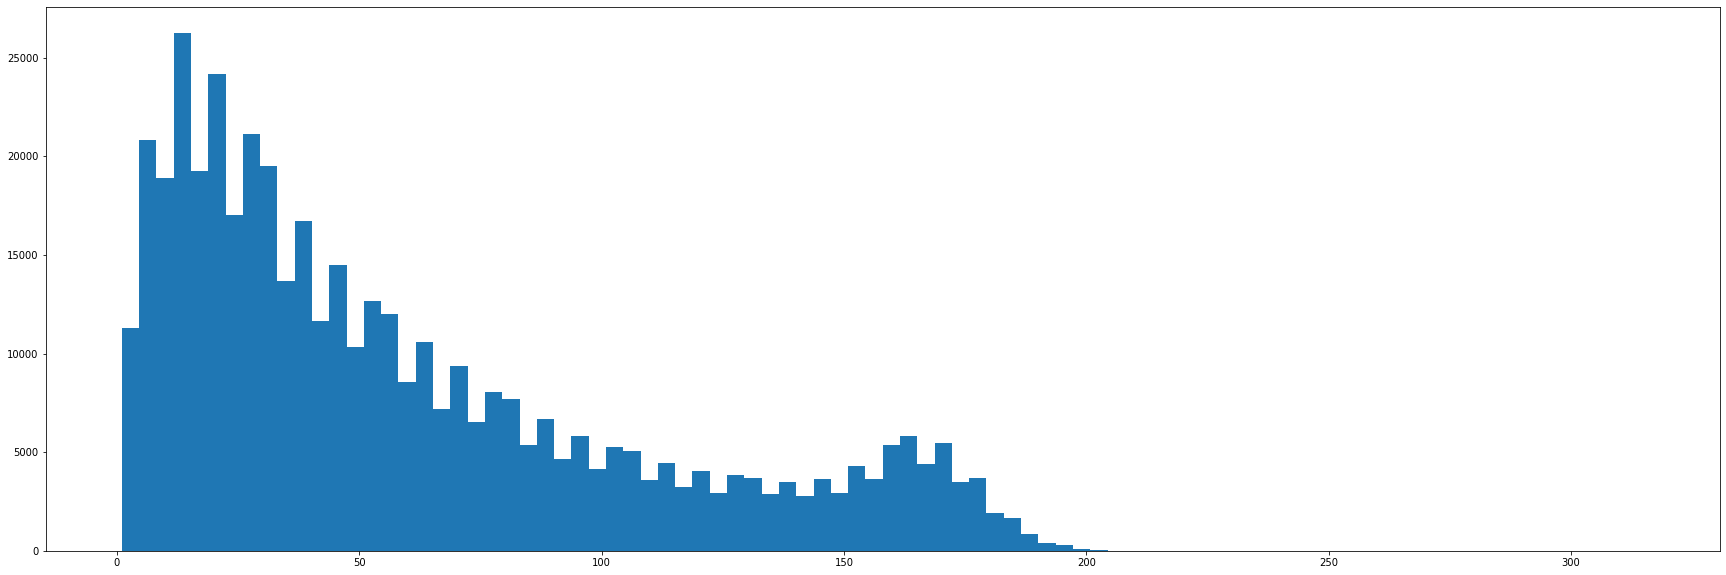

In [63]:
q10, q90 = np.percentile(word_histogram, [10, 90])
print(q10)
print(q90)
bin_width = 2 * (q90 - q10) * len(word_histogram) ** (-1/3)
bins = round((max(word_histogram) - min(word_histogram)) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(word_histogram, bins=bins);

Freedman–Diaconis number of bins: 179


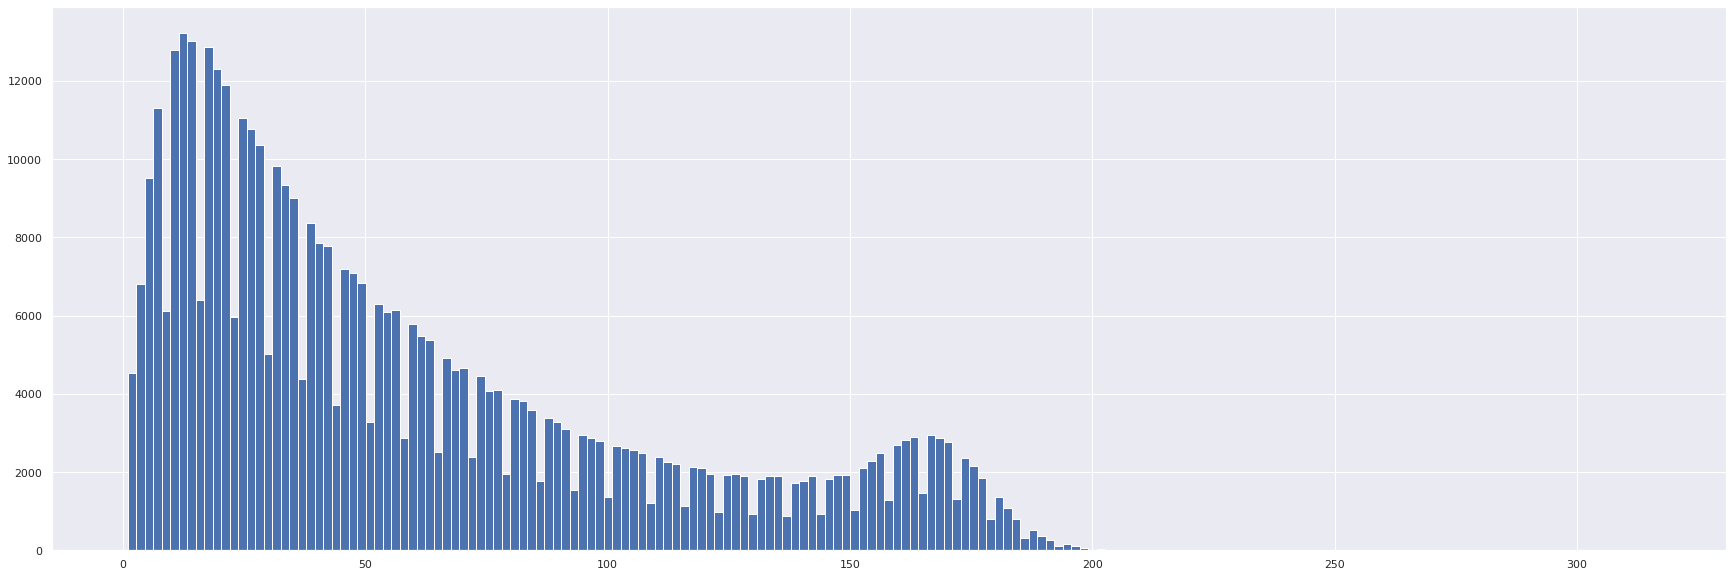

In [32]:
q25, q75 = np.percentile(word_histogram, [25, 75])
bin_width = 2 * (q75 - q25) * len(word_histogram) ** (-1/3)
bins = round((max(word_histogram) - min(word_histogram)) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(word_histogram, bins=bins);

In [34]:
min(word_histogram)

1

In [35]:
max(word_histogram)

315

In [37]:
for data in full_dataset_inputs:
    if len(data.split()) == 315:
        print(data)

As usual WW plumbing the depths for deeper meaning ... that is unless it involves an issue on which they disagree then it is ridicule 24/7.   Clever creating the Bundyland series complete with cartoon banner.  Set the tone for the level of journalism to expect ... journalism ?  ... fatastisticism. 

I did notice you soft pedaling the ridicule of David Fry identifying him as troubled.  My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics.  Respect is never a factor with liberals as evidenced by your series of vapid caricatures.  

Did you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge?  The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon.  Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbi

In [5]:
full_dataset_inputs = full_dataset._text_array
len(full_dataset_inputs)


448000

In [6]:
print(full_dataset_inputs[0])

OH yes - Were those evil Christian Missionaries (many of whom were slaughtered by the Indians, or lost their lives due to disease, starvation etc.) lumped in with those "genocidists" you mention ? (yes I did make up a word, just as you make up stories).


In [7]:
print(full_dataset_inputs[0].split())

['OH', 'yes', '-', 'Were', 'those', 'evil', 'Christian', 'Missionaries', '(many', 'of', 'whom', 'were', 'slaughtered', 'by', 'the', 'Indians,', 'or', 'lost', 'their', 'lives', 'due', 'to', 'disease,', 'starvation', 'etc.)', 'lumped', 'in', 'with', 'those', '"genocidists"', 'you', 'mention', '?', '(yes', 'I', 'did', 'make', 'up', 'a', 'word,', 'just', 'as', 'you', 'make', 'up', 'stories).']


In [ ]:
full_dataset_inputs = full_dataset._text_array

for i in range(5):
    data = full_dataset_inputs[i]
    print(data)
    print(data.split())

Freedman–Diaconis number of bins: 25037


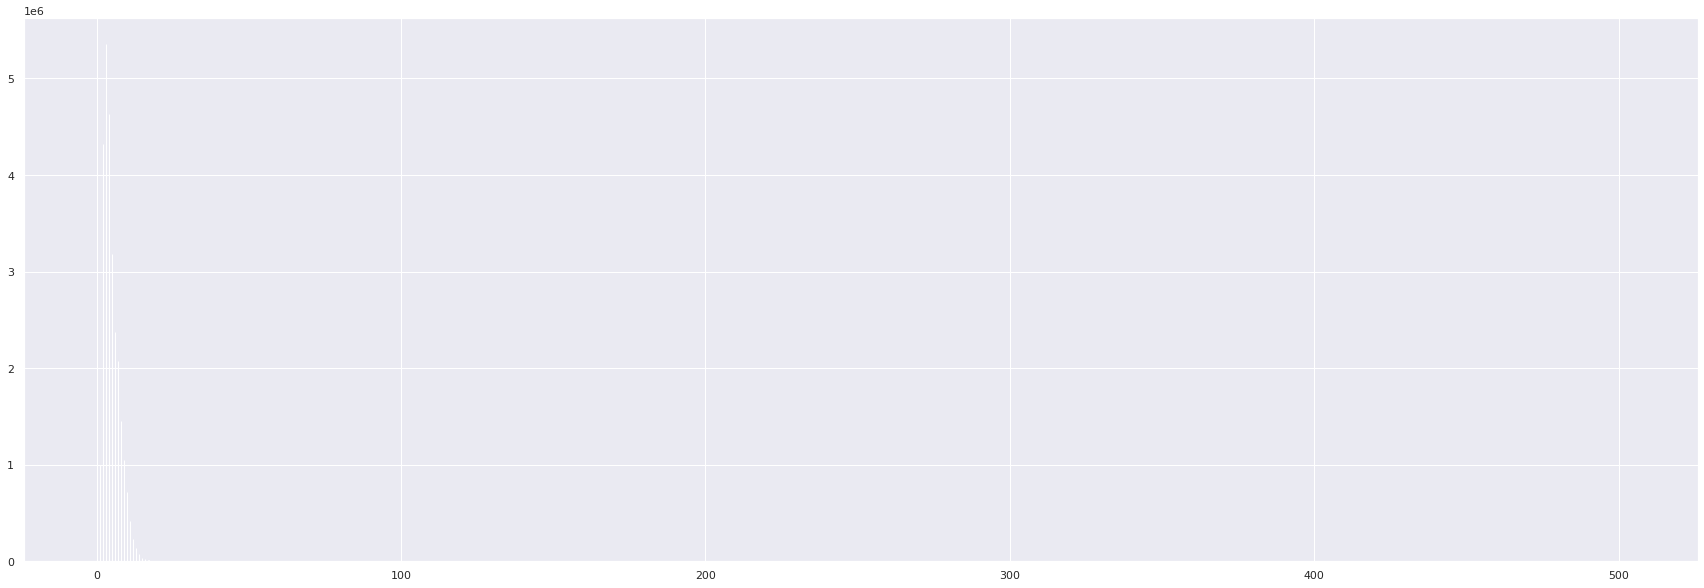

In [75]:
q25, q75 = np.percentile(char_histogram, [25, 75])
bin_width = 2 * (q75 - q25) * len(char_histogram) ** (-1/3)
bins = round((max(char_histogram) - min(char_histogram)) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(char_histogram, bins=bins);

In [76]:
print(q25)
print(q75)

3.0
6.0


In [38]:
min(char_histogram)

1

In [39]:
max(char_histogram)

1891

In [40]:
for data in full_dataset_inputs:
    if len(data) == 1:
        print(data)

d
.
g
?
?
?
.
🤔
😥
☺
K
,
.
.
1
r
?


In [41]:
for data in full_dataset_inputs:
    if len(data) == 1891:
        print(data)

As usual WW plumbing the depths for deeper meaning ... that is unless it involves an issue on which they disagree then it is ridicule 24/7.   Clever creating the Bundyland series complete with cartoon banner.  Set the tone for the level of journalism to expect ... journalism ?  ... fatastisticism. 

I did notice you soft pedaling the ridicule of David Fry identifying him as troubled.  My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics.  Respect is never a factor with liberals as evidenced by your series of vapid caricatures.  

Did you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge?  The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon.  Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbi

In [ ]:
""" 
EXPERIMENT: IMPACT OF CHAR AUGMENTATION FREQUENCY ON ACCURACY
"""

char_augmentation = 'nlp_random_char_deletion'

for i in range(1, 5):
    predict_augmented_labels(char_augmentation, aug_size = i)


In [39]:
def create_char_exp_accuracy_graph(exp_folder, graph_type = 'bar'):
    
    aug_to_acc = []
    
    print(exp_folder)
    percent_words_modified = os.listdir(exp_folder)[0][7:11] # HOW TO GET PERC. WORDS

    for filename in os.listdir(exp_folder):
        print(filename)
        full_path = exp_folder + '/' + filename
        #print(full_path)
        if os.path.isfile(full_path):
            accuracies = calculate_accuracy(full_path)
            num_char = filename[-5:-4] # HOW TO GET NUMBER OF CHARACTERS

            for i in range(len(accuracies)):
                accuracy = accuracies[i]
                aug_dict = {"num_char_augmented":num_char, "accuracy": accuracy, "batch_num": i}
                aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('num_char_augmented', ascending = True)
    print(acc_df)
    
    fig, ax = plt.subplots()

    if graph_type == 'bar':
        p = sns.barplot(x = 'num_char_augmented', y = 'accuracy', data = acc_df, ci = 95, ax = ax)#, order = acc_df['augmentation'])
    
    elif graph_type == 'box':
        p = sns.boxplot(x = 'num_char_augmented', y = 'accuracy', data = acc_df, ax = ax)#, order = acc_df['augmentation'])


    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    
    #print(p.containers[0])
    #p.bar_label(p.containers[0])
    show_values(p)
    plt.rcParams['figure.figsize'] = (30,10)
    
    print(percent_words_modified)
    title = str(percent_words_modified) + " of input modified with nlpaug_random_char_deletion"
    
    plt.title(title)
    plt.show()
    


In [79]:
def create_exp_accuracy_summary_plot(exp_folders):
    aug_to_acc = []
    hue_order = []
    

    for folder in exp_folders:
        percent_words_modified = os.listdir(folder)[0][7:11] # HOW TO GET PERC. WORDS
        hue_order.append(percent_words_modified)
        
        for filename in os.listdir(folder):
            print(filename)
            full_path = folder + '/' + filename
            
            if os.path.isfile(full_path):
                accuracies = calculate_accuracy(full_path)
                num_char = filename[-5:-4] # HOW TO GET NUMBER OF CHARACTERS

                for i in range(len(accuracies)):
                    accuracy = accuracies[i]
                    aug_dict = {"num_char_augmented":num_char, "accuracy": accuracy, "perc_words_augmented": percent_words_modified, "batch_num": i}
                    aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('num_char_augmented', ascending = True)
    print(acc_df)
    
    fig, ax = plt.subplots()

    p = sns.lineplot(data = acc_df, x = "num_char_augmented", y = "accuracy", hue = "perc_words_augmented", hue_order = hue_order, ax = ax)#, order = acc_df['augmentation'])
    
    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    
    #ax.add_legend(label_order = exp_folders)
    
    #print(p.containers[0])
    #p.bar_label(p.containers[0])
    show_values(p)
    #plt.rcParams['figure.figsize'] = (20,10)
    
    print(percent_words_modified)
    title = "Impact of nlpaug_random_char_deletion augmentation intensity on predictive accuracy"
    
    plt.title(title)
    plt.show()
    



In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment')

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.25')

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.50')

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.75', graph_type = 'box')

In [ ]:
experiment_folders = [
                     'ERM_char_frequency_experiment/word_p_0.05',
                     'ERM_char_frequency_experiment/word_p_0.10',
                     'ERM_char_frequency_experiment/word_p_0.20',
                     'ERM_char_frequency_experiment/word_p_0.25',
                     'ERM_char_frequency_experiment/word_p_0.50',
                     'ERM_char_frequency_experiment/word_p_0.75',
                     ]

create_exp_accuracy_summary_plot(experiment_folders)

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.05')

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.10')

In [ ]:
create_char_exp_accuracy_graph('ERM_char_frequency_experiment/word_p_0.20')

In [ ]:
""" 
EXPERIMENT: IMPACT OF WORD AUGMENTATION INTENSITY ON ACCURACY
"""

word_augmentation = 'nlp_random_word_delete'

for i in range(2, 11):
    predict_augmented_labels(word_augmentation, aug_size = i)


In [35]:
def create_word_exp_accuracy_graph(exp_folder, graph_type = 'bar'):
    
    aug_to_acc = []
    
    print(exp_folder)

    for filename in os.listdir(exp_folder):
        print(filename)
        full_path = exp_folder + '/' + filename
        #print(full_path)
        if os.path.isfile(full_path):
            accuracies = calculate_accuracy(full_path)
            num_word = filename.split('_')[-1].split('.')[0] # HOW TO GET NUMBER OF CHARACTERS

            for i in range(len(accuracies)):
                accuracy = accuracies[i]
                aug_dict = {"num_word_augmented":int(num_word), "accuracy": accuracy, "batch_num": i}
                aug_to_acc.append(aug_dict)

    
    acc_df = pd.DataFrame(aug_to_acc).sort_values('num_word_augmented', ascending = True)
    print(acc_df)
    
    fig, ax = plt.subplots()

    if graph_type == 'bar':
        p = sns.barplot(x = 'num_word_augmented', y = 'accuracy', data = acc_df, ci = 95, ax = ax)#, order = acc_df['augmentation'])
    
    elif graph_type == 'box':
        p = sns.boxplot(x = 'num_word_augmented', y = 'accuracy', data = acc_df, ax = ax)#, order = acc_df['augmentation'])


    min_value = acc_df.min()['accuracy']
    max_value = acc_df.max()['accuracy']

    ax.set_ylim(min_value - 0.02, min(1.0, max_value + 0.02))
    
    show_values(p)
    plt.rcParams['figure.figsize'] = (30,10)
    
    title = "input modified with nlpaug_random_word_delete"
    
    plt.title(title)
    plt.show()
    


ERM_word_frequency_experiment
nlp_random_word_delete_aug_size_10.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_3.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_6.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_2.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_9.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_5.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_8.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_1.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_7.npy


  0%|          | 0/10 [00:00<?, ?it/s]

nlp_random_word_delete_aug_size_4.npy


  0%|          | 0/10 [00:00<?, ?it/s]

    num_word_augmented  accuracy  batch_num
79                   1  0.924485          9
70                   1  0.924167          0
71                   1  0.923737          1
72                   1  0.924410          2
73                   1  0.924541          3
..                 ...       ...        ...
6                   10  0.911208          6
7                   10  0.911852          7
9                   10  0.911441          9
5                   10  0.911021          5
0                   10  0.911152          0

[100 rows x 3 columns]


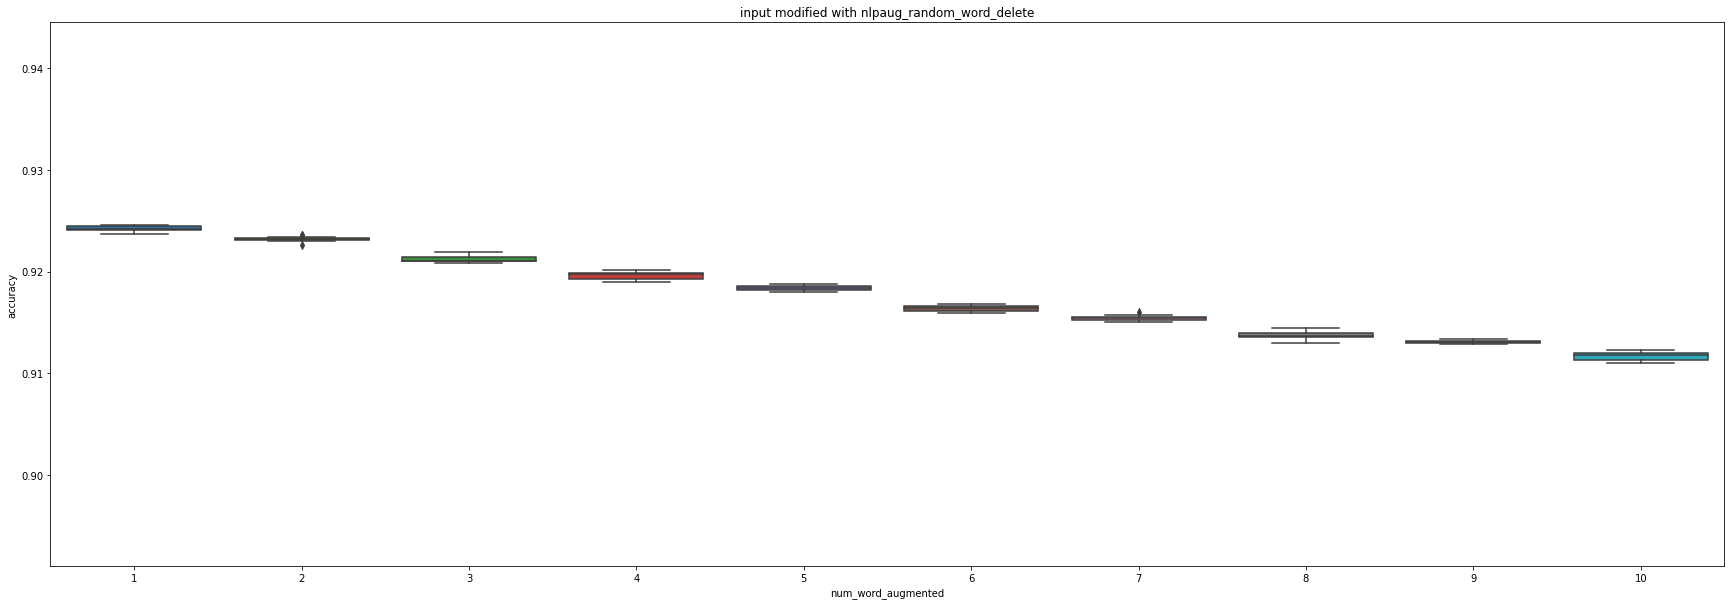

In [37]:
create_word_exp_accuracy_graph('ERM_word_frequency_experiment', graph_type = 'box')